In [ ]:
!pip install -q catboost

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [6]:
validate = pd.read_parquet("/Users/samsanovicekaterina/dl.25/parquet_files/validate_agg_f.parquet")
user_agg = pd.read_parquet("/Users/samsanovicekaterina/dl.25/parquet_files/user_aggregates.parquet")
publisher_agg = pd.read_parquet("/Users/samsanovicekaterina/dl.25/parquet_files/publisher_aggregates.parquet")
history = pd.read_csv("/Users/samsanovicekaterina/dl.25/data/history.tsv", sep="\t")
answers = pd.read_csv("/Users/samsanovicekaterina/dl.25/data/validate_answers.tsv", sep ='\t')
validate_begin = pd.read_csv("/Users/samsanovicekaterina/dl.25/data/validate.tsv", sep ='\t')

In [7]:
history


,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148
...,...,...,...,...
1147852,382,45.00,1,7871
1147853,360,33.35,1,7992
1147854,381,205.00,1,21516
1147855,383,37.50,1,8224


In [8]:
user_agg

,user_id,total_impressions,mean_cpm,median_cpm,max_cpm
0,0,2.0,2053.830000,2053.830,3302.01
1,1,82.0,124.068049,90.000,1140.00
2,2,0.0,0.000000,0.000,0.00
3,3,8.0,370.880000,288.130,715.92
4,4,132.0,44.627955,30.160,255.36
...,...,...,...,...,...
27764,27764,43.0,210.409767,170.000,958.11
27765,27765,79.0,146.901013,110.640,608.48
27766,27766,54.0,159.045741,123.525,755.00
27767,27767,1.0,143.880000,143.880,143.88


In [7]:
publisher_agg

,publisher,total_impressions,mean_cpm
0,1,692535,177.567497
1,2,273037,203.134623
2,3,72124,195.899285
3,4,2286,92.164563
4,5,7263,183.900573
5,6,5935,87.411821
6,7,66134,244.468823
7,8,3625,115.163796
8,9,10165,98.388453
9,10,4232,108.062290


In [9]:
validate


,cpm,hour_start,hour_end,publishers,audience_size,user_ids,hour_start_of_day,hour_end_of_day,campaign_duration,num_publishers,...,pub_mean_hour_of_day,pub_mean_imp_per_user,pub_premium_ratio,pub_high_volume_ratio,cpm_x_duration,cpm_x_audience,cpm_per_hour,cpm_deviation,aud_pub_quality,campaign_intensity
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,1,95,2,...,13.949551,11.129670,0.500000,0.500000,20900.0,419320.0,2.291667,57.192969,8516.907959,0.001215
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",23,5,6,2,...,13.436928,14.426752,0.500000,0.500000,1872.0,430560.0,44.571429,132.960506,19420.318158,0.037677
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",5,1,20,6,...,12.946205,23.472567,0.333333,0.666667,1400.0,62160.0,3.333333,211.236039,6415.570042,0.003941
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",23,9,82,2,...,12.684560,26.600548,0.500000,0.500000,19680.0,105600.0,2.891566,13.803214,7248.434091,0.006652
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",8,6,238,4,...,13.290715,21.628911,0.500000,0.750000,62356.0,386712.0,1.096234,65.261172,6510.727298,0.000746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,127.0,1095,1154,"[2, 7, 12, 15, 16]",368,"[38, 50, 143, 237, 456, 649, 653, 698, 881, 89...",15,2,59,5,...,13.347756,16.445638,0.400000,0.400000,7493.0,46736.0,2.116667,124.821533,6015.421677,0.005849
1004,90.0,1052,1056,"[2, 21]",484,"[1, 4, 61, 212, 230, 348, 356, 372, 429, 431, ...",20,0,4,2,...,12.323577,25.236782,0.500000,0.500000,360.0,43560.0,18.000000,141.280577,5208.411890,0.046464
1005,122.0,1058,1063,"[2, 5]",704,"[1, 23, 29, 104, 136, 176, 201, 206, 250, 269,...",2,7,5,2,...,13.177356,29.247989,0.500000,0.500000,610.0,85888.0,20.333333,56.998032,22425.775835,0.034649
1006,138.0,932,1169,"[1, 2, 7]",1210,"[67, 73, 80, 146, 182, 202, 212, 254, 307, 377...",20,17,237,3,...,13.528322,34.232781,0.666667,1.000000,32706.0,166980.0,0.579832,112.687855,7325.866776,0.000481


In [9]:
def generate_pseudo_target(row, history): #row: одна строка из validate,history: датафрейм с историей показов (user_id, publisher, hour)
    users_in_campaign = row["user_ids"]
    publishers_in_campaign = row["publishers"]


    if len(users_in_campaign) == 0 or len(publishers_in_campaign) == 0:
        return pd.Series({
            "at_least_1": 0.0,
            "at_least_2": 0.0,
            "at_least_3": 0.0
        })

    relevant_history = history[
        (history["user_id"].isin(users_in_campaign)) &
        (history["publisher"].isin(publishers_in_campaign))
    ]

    user_counts = relevant_history.groupby("user_id")["hour"].count()
    total_users = len(users_in_campaign)

    return pd.Series({
        "at_least_1": (user_counts >= 1).sum() / 27769,
        "at_least_2": (user_counts >= 2).sum() / 27769,
        "at_least_3": (user_counts >= 3).sum() / 27769
    })


In [10]:
tqdm.pandas()
validate_targets = validate.progress_apply(lambda row: generate_pseudo_target(row, history), axis=1)
validate = pd.concat([validate, validate_targets], axis=1)


100%|██████████| 1008/1008 [00:56<00:00, 17.78it/s]


In [11]:
validate

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,duration,hour_start_of_day,hour_end_of_day,aud_mean_imp,aud_median_imp,aud_mean_cpm,aud_median_cpm,aud_max_cpm,at_least_1,at_least_2,at_least_3
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",95,2,1,40.567156,15.0,277.192969,223.064971,56579.07,0.014621,0.010371,0.008751
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",6,23,5,128.990580,105.0,179.039494,129.313120,36395.60,0.005870,0.004645,0.004177
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",20,5,1,43.977477,16.0,281.236039,211.638046,209053.98,0.026072,0.023840,0.022147
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",82,23,9,38.665909,15.5,253.803214,204.578409,56579.07,0.008607,0.007886,0.007418
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",238,8,6,35.524390,11.0,327.261172,271.450901,38282.14,0.038748,0.034823,0.032086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,127.0,1095,1154,"[2, 7, 12, 15, 16]",368,"[38, 50, 143, 237, 456, 649, 653, 698, 881, 89...",59,15,2,37.201087,12.0,251.821533,211.496372,19488.36,0.005078,0.004033,0.003601
1004,90.0,1052,1056,"[2, 21]",484,"[1, 4, 61, 212, 230, 348, 356, 372, 429, 431, ...",4,20,0,41.793388,15.0,231.280577,180.850279,18233.68,0.004069,0.003709,0.003673
1005,122.0,1058,1063,"[2, 5]",704,"[1, 23, 29, 104, 136, 176, 201, 206, 250, 269,...",5,2,7,115.884943,94.5,178.998032,130.320305,36853.28,0.007094,0.006986,0.006842
1006,138.0,932,1169,"[1, 2, 7]",1210,"[67, 73, 80, 146, 182, 202, 212, 254, 307, 377...",237,20,17,35.154545,10.0,250.687855,204.051174,8677.35,0.034787,0.030862,0.028305


Проверка, что значения упорядочены по убыванию

In [12]:
violations = (validate["at_least_1"] < validate["at_least_2"]) | \
             (validate["at_least_2"] < validate["at_least_3"])

num_violations = violations.sum()
print(f"Количество нарушений порядка: {num_violations}")
if num_violations > 0:
    print(validate.loc[violations].head())
else:
    print("Все строки корректны: at_least_one >= at_least_two >= at_least_three")


Количество нарушений порядка: 0
Все строки корректны: at_least_one >= at_least_two >= at_least_three


In [13]:
def agg_publisher_features(publisher_ids, publisher_agg):
    pubs = publisher_agg[publisher_agg["publisher"].isin(publisher_ids)]
    if len(pubs) == 0:
        return pd.Series({"pub_mean_imp":0.0, "pub_mean_cpm":0.0})
    return pd.Series({
        "pub_mean_imp": pubs["total_impressions"].mean(),
        "pub_mean_cpm": pubs["mean_cpm"].mean()
    })

tqdm.pandas(desc="фичи площадок")
pub_feats = validate["publishers"].progress_apply(lambda pubs: agg_publisher_features(pubs, publisher_agg))
validate = pd.concat([validate, pub_feats], axis=1)

фичи площадок: 100%|██████████| 1008/1008 [00:01<00:00, 652.74it/s]


In [14]:
validate = pd.concat([validate, pub_feats], axis=1)
validate

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,duration,hour_start_of_day,hour_end_of_day,aud_mean_imp,...,aud_mean_cpm,aud_median_cpm,aud_max_cpm,at_least_1,at_least_2,at_least_3,pub_mean_imp,pub_mean_cpm,pub_mean_imp,pub_mean_cpm
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",95,2,1,40.567156,...,277.192969,223.064971,56579.07,0.014621,0.010371,0.008751,33614.50,209.945895,33614.50,209.945895
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",6,23,5,128.990580,...,179.039494,129.313120,36395.60,0.005870,0.004645,0.004177,36160.00,150.556096,36160.00,150.556096
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",20,5,1,43.977477,...,281.236039,211.638046,209053.98,0.026072,0.023840,0.022147,174739.00,145.883084,174739.00,145.883084
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",82,23,9,38.665909,...,253.803214,204.578409,56579.07,0.008607,0.007886,0.007418,346795.00,187.463175,346795.00,187.463175
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",238,8,6,35.524390,...,327.261172,271.450901,38282.14,0.038748,0.034823,0.032086,208604.50,183.274850,208604.50,183.274850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,127.0,1095,1154,"[2, 7, 12, 15, 16]",368,"[38, 50, 143, 237, 456, 649, 653, 698, 881, 89...",59,15,2,37.201087,...,251.821533,211.496372,19488.36,0.005078,0.004033,0.003601,68597.60,161.700159,68597.60,161.700159
1004,90.0,1052,1056,"[2, 21]",484,"[1, 4, 61, 212, 230, 348, 356, 372, 429, 431, ...",4,20,0,41.793388,...,231.280577,180.850279,18233.68,0.004069,0.003709,0.003673,136523.00,124.622867,136523.00,124.622867
1005,122.0,1058,1063,"[2, 5]",704,"[1, 23, 29, 104, 136, 176, 201, 206, 250, 269,...",5,2,7,115.884943,...,178.998032,130.320305,36853.28,0.007094,0.006986,0.006842,140150.00,193.517598,140150.00,193.517598
1006,138.0,932,1169,"[1, 2, 7]",1210,"[67, 73, 80, 146, 182, 202, 212, 254, 307, 377...",237,20,17,35.154545,...,250.687855,204.051174,8677.35,0.034787,0.030862,0.028305,343902.00,208.390314,343902.00,208.390314


In [10]:
validate.columns

Index(['cpm', 'hour_start', 'hour_end', 'publishers', 'audience_size',
       'user_ids', 'hour_start_of_day', 'hour_end_of_day', 'campaign_duration',
       'num_publishers', 'coverage_morning', 'coverage_afternoon',
       'coverage_evening', 'coverage_night', 'aud_mean_imp', 'aud_median_imp',
       'aud_std_imp', 'aud_mean_cpm', 'aud_median_cpm', 'aud_std_cpm',
       'aud_mean_pub_diversity', 'aud_mean_hour_of_day', 'aud_morning_ratio',
       'aud_afternoon_ratio', 'aud_evening_ratio', 'aud_night_ratio',
       'pub_mean_impressions', 'pub_mean_unique_users', 'pub_mean_cpm',
       'pub_median_cpm', 'pub_std_cpm', 'pub_mean_unique_cities',
       'pub_mean_age', 'pub_mean_male_ratio', 'pub_mean_hour_of_day',
       'pub_mean_imp_per_user', 'pub_premium_ratio', 'pub_high_volume_ratio',
       'cpm_x_duration', 'cpm_x_audience', 'cpm_per_hour', 'cpm_deviation',
       'aud_pub_quality', 'campaign_intensity'],
      dtype='object')

In [12]:
feature_groups = {
    'Базовые параметры кампании': [
        'cpm',
        'campaign_duration',
        'num_publishers',
        'audience_size',
        'cpm_per_hour',
        'cpm_x_duration',
        'cpm_x_audience',
        'campaign_intensity'
    ],

    'Временные характеристики': [
        'hour_start_of_day',
        'hour_end_of_day',
        'coverage_morning',
        'coverage_afternoon',
        'coverage_evening',
        'coverage_night'
    ],
    
    'Аудитория: активность и опыт': [
        'aud_mean_imp',
        'aud_median_imp',
        'aud_std_imp',
        'aud_mean_pub_diversity'
    ],
    
    'Аудитория: CPM профиль': [
        'aud_mean_cpm',
        'aud_median_cpm',
        'aud_std_cpm',
        'cpm_deviation'
    ],

    'Аудитория: временные паттерны': [
        'aud_mean_hour_of_day',
        'aud_morning_ratio',
        'aud_afternoon_ratio',
        'aud_evening_ratio',
        'aud_night_ratio'
    ],
    
    'Площадки: объём и охват': [
        'pub_mean_impressions',
        'pub_mean_unique_users',
        'pub_mean_imp_per_user',
        'pub_mean_unique_cities',
        'pub_premium_ratio',
        'pub_high_volume_ratio'
    ],
    
    'Площадки: CPM и демография': [
        
        'pub_mean_cpm',
        'pub_median_cpm',
        'pub_std_cpm',
        'pub_mean_age',
        'pub_mean_male_ratio',
        'pub_mean_hour_of_day'
    ],

    'Взаимодействия признаков': [
        'cpm',
        'aud_mean_cpm',
        'pub_mean_cpm',
        'cpm_deviation',
        'aud_pub_quality',
        'campaign_intensity'
    ]
}

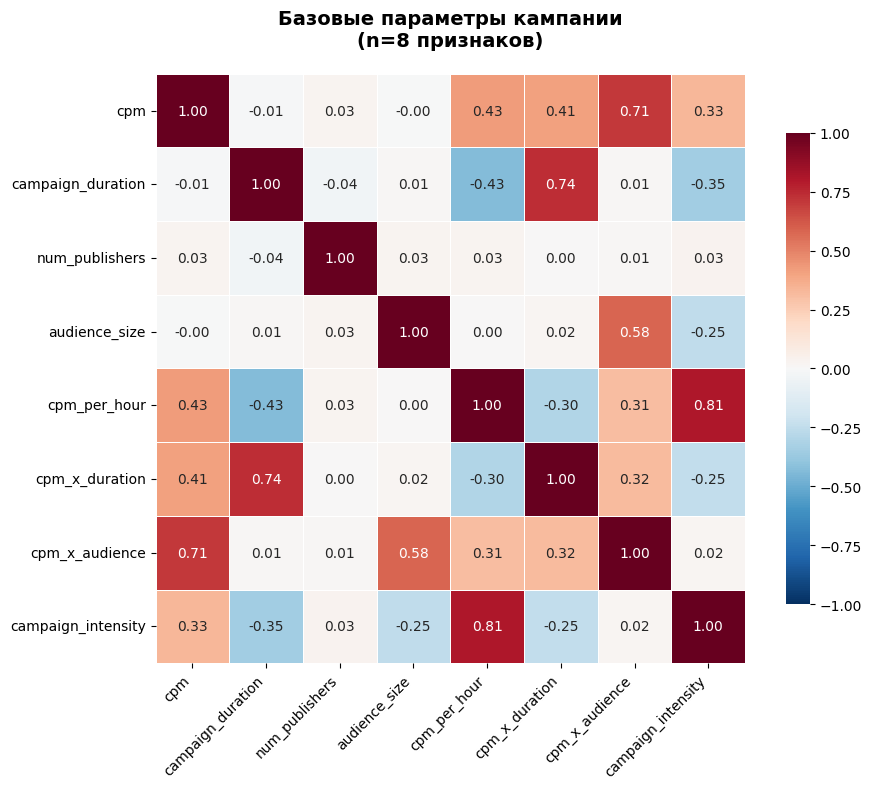

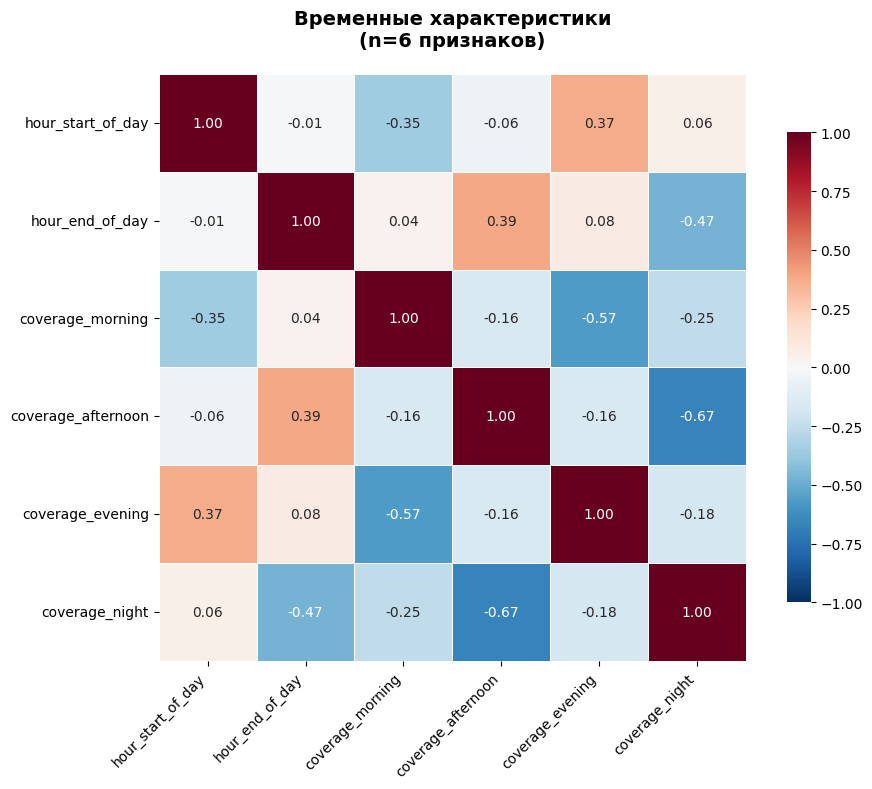

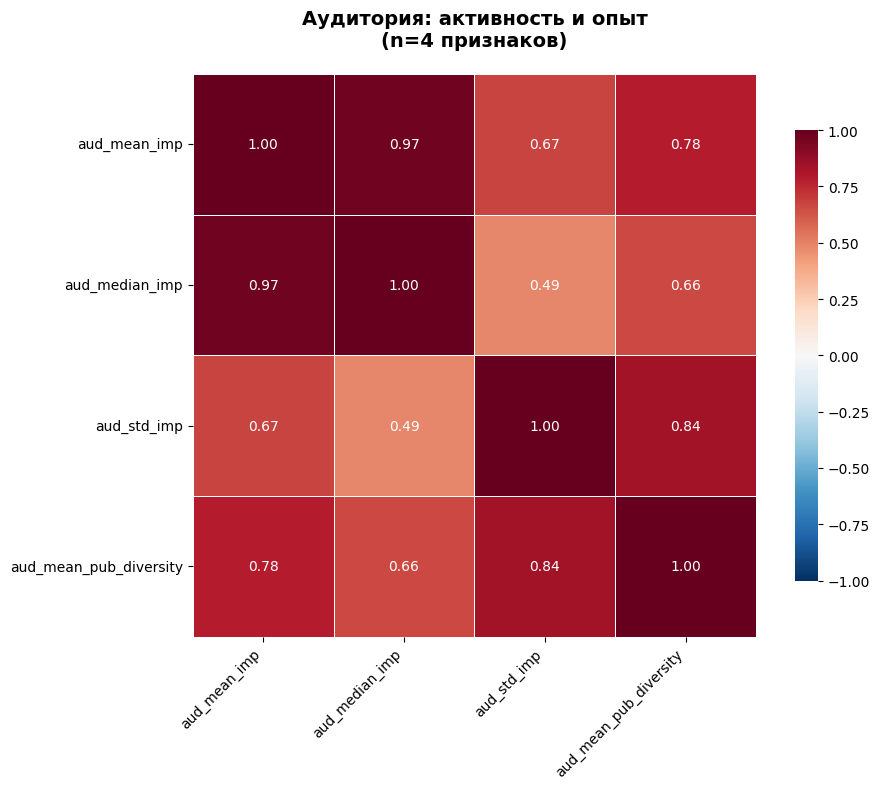

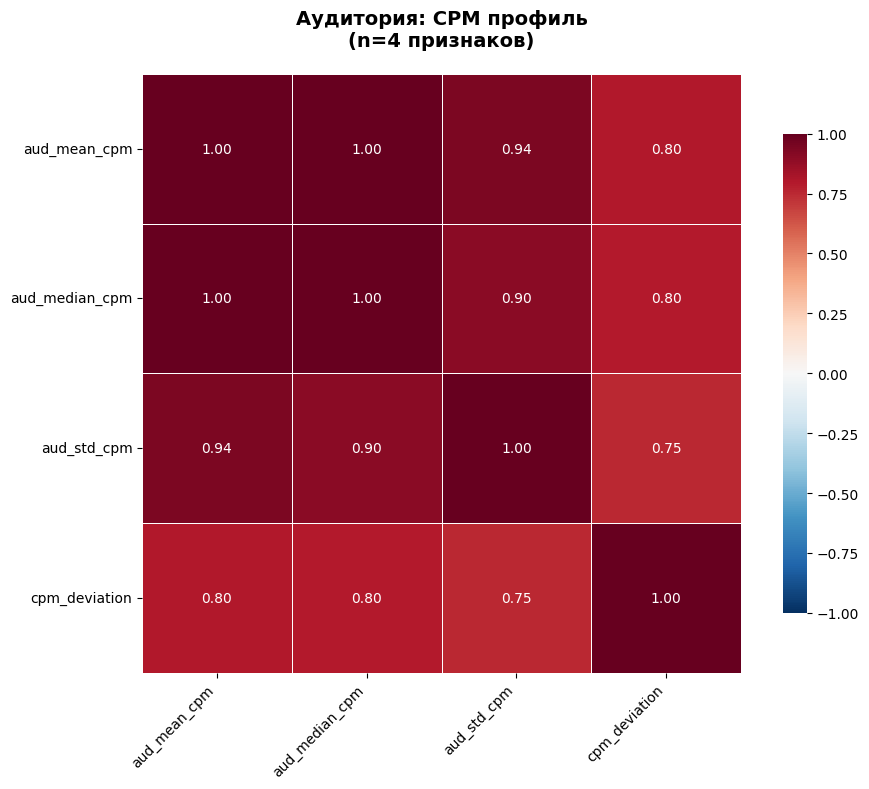

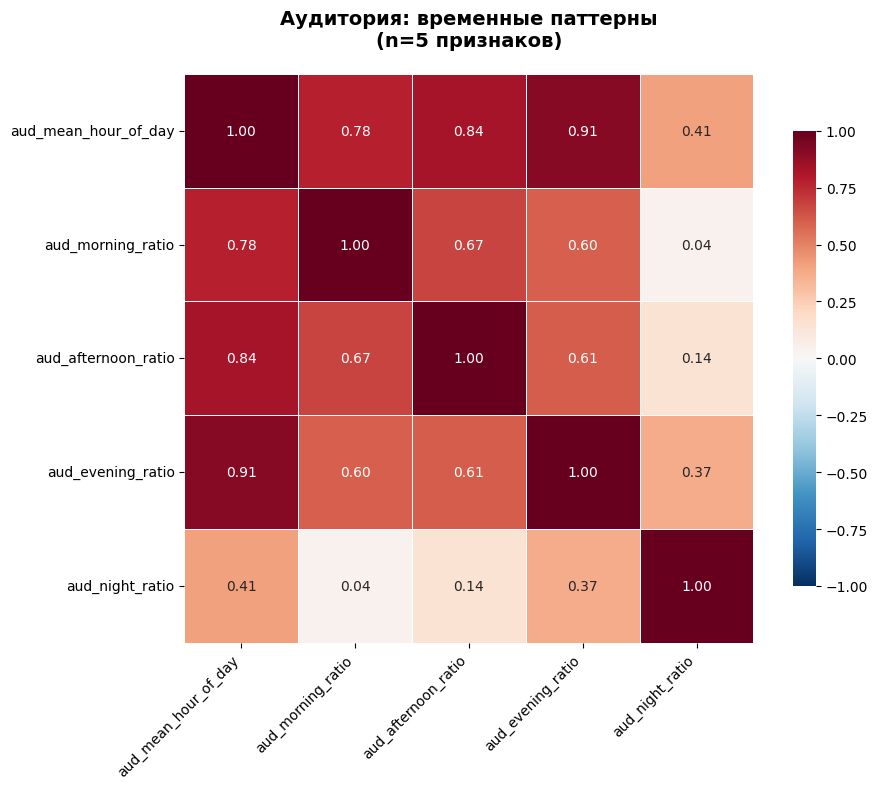

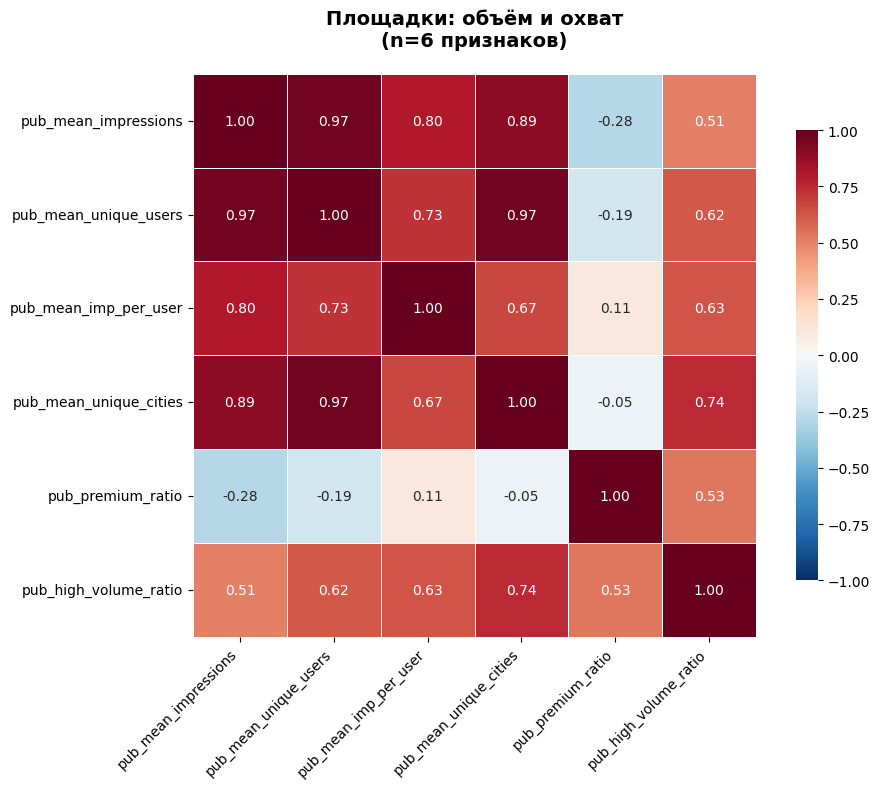

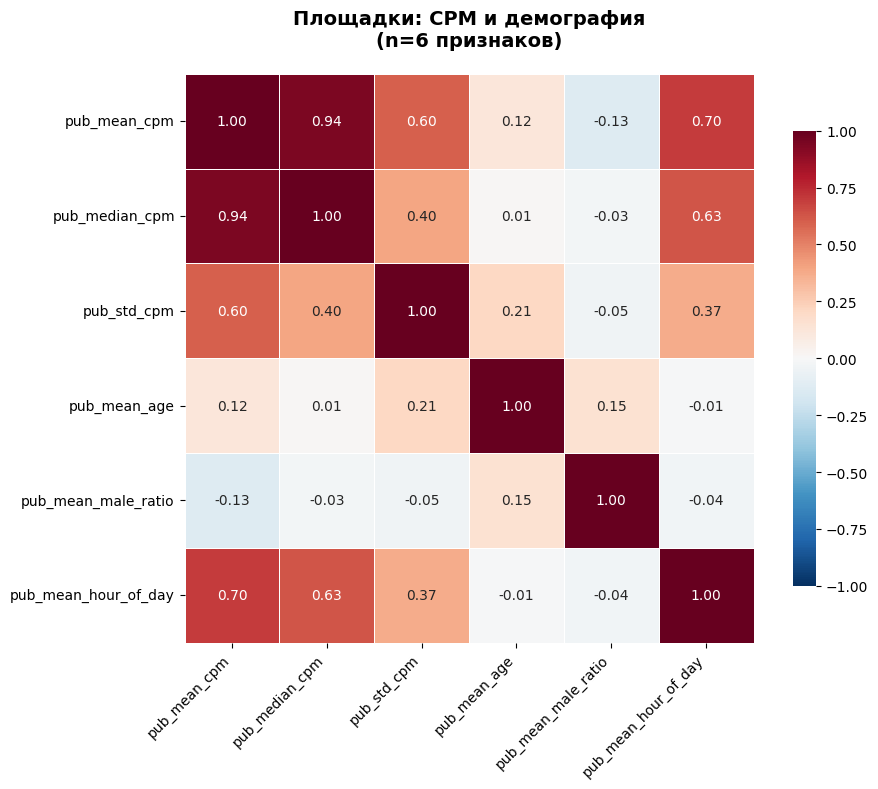

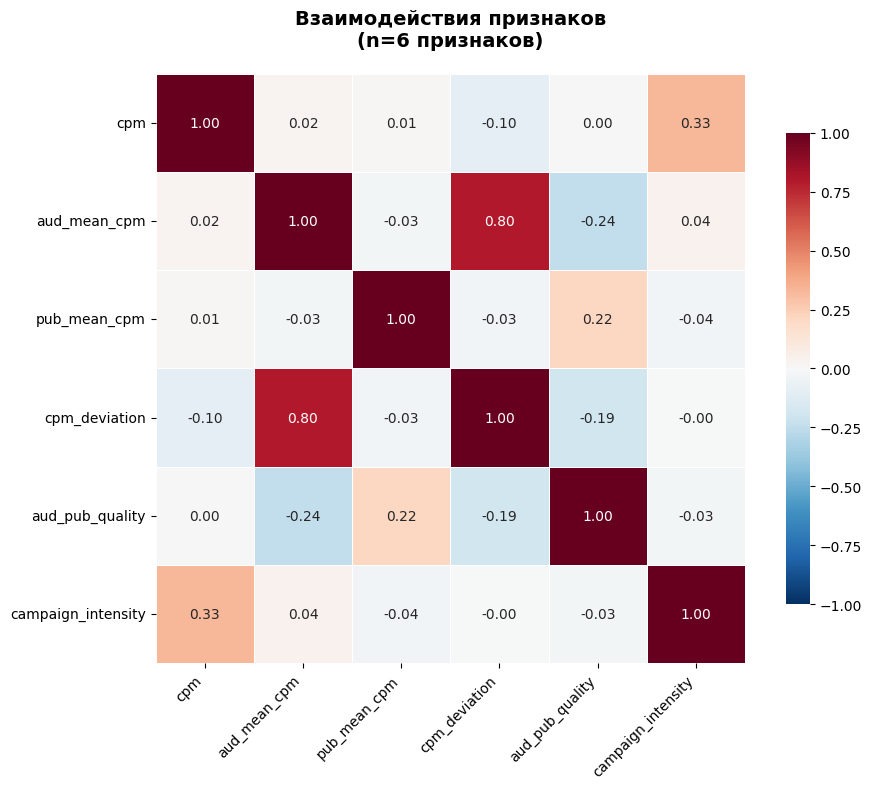

In [ ]:
def plot_correlation_matrix(data, features, title, figsize=(10, 8)):
    existing_features = [f for f in features if f in data.columns]
    corr = data[existing_features].corr()

    plt.figure(figsize=figsize)

    sns.heatmap(
        corr,
        annot=True,
        fmt='.2f',
        cmap='RdBu_r',
        center=0,
        vmin=-1,
        vmax=1,
        square=True,
        linewidths=0.5,
        cbar_kws={'shrink': 0.8}
    )
    
    plt.title(f'{title}\n(n={len(existing_features)} признаков)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    print()

for group_name, features in feature_groups.items():
    plot_correlation_matrix(validate, features, group_name)

In [11]:
validate = validate.copy()
validate["at_least_one"]   = answers["at_least_one"].values
validate["at_least_two"]   = answers["at_least_two"].values
validate["at_least_three"] = answers["at_least_three"].values

In [17]:
num_cols = [
    "cpm",
    "audience_size",
    "duration",
    "hour_start_of_day",
    "hour_end_of_day",

    "aud_mean_imp",
    "aud_median_imp",
    "aud_mean_cpm",
    "aud_median_cpm",
    "aud_max_cpm",

    "pub_mean_imp",
    "pub_mean_cpm",

    'at_least_1',
    'at_least_2',
    'at_least_3',

    "at_least_one",
    "at_least_two",
    "at_least_three"
]


In [19]:
validate_preds = validate[[
    "at_least_one",
    "at_least_two",
    "at_least_three"
]].copy()

1. Catboost

In [20]:
target_cols = [
    "at_least_one",
    "at_least_two",
    "at_least_three"
]

num_cols = [
    "cpm",
    "audience_size",
    "duration",
    "hour_start_of_day",
    "hour_end_of_day",

    "aud_mean_imp",
    "aud_median_imp",
    "aud_mean_cpm",
    "aud_median_cpm",
    "aud_max_cpm",

    'at_least_1',
    'at_least_2',
    'at_least_3',

    "pub_mean_imp",
    "pub_mean_cpm"
]


X = validate[num_cols]
X = X.loc[:, ~X.columns.duplicated()]
y = validate[target_cols].values.astype(np.float32)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [21]:
X_train

,cpm,audience_size,duration,hour_start_of_day,hour_end_of_day,aud_mean_imp,aud_median_imp,aud_mean_cpm,aud_median_cpm,aud_max_cpm,at_least_1,at_least_2,at_least_3,pub_mean_imp,pub_mean_cpm
29,80.0,328,30,19,1,51.942073,22.0,204.493249,160.359162,23624.78,0.006554,0.006086,0.005798,692535.000000,177.567497
280,446.0,880,22,20,18,38.321591,13.0,253.188686,210.475523,17678.28,0.025604,0.023263,0.021859,259697.750000,188.006093
507,50.0,1232,364,16,20,55.666396,24.0,440.663210,356.707281,209053.98,0.029745,0.026252,0.024452,152241.800000,175.838063
652,30.0,744,34,4,14,12.438172,4.0,926.047709,781.924227,64282.98,0.022183,0.017466,0.014765,175527.000000,167.686543
948,160.0,2480,62,3,17,195.137903,170.0,152.122842,107.119331,57922.89,0.071771,0.069898,0.068710,254098.000000,179.066705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,100.0,936,3,22,1,120.951923,98.0,184.948387,131.962222,56579.07,0.026828,0.026288,0.025820,152998.400000,131.794257
270,133.0,480,28,4,8,28.681250,7.0,240.389556,206.382000,7603.20,0.004681,0.003349,0.002629,47428.666667,179.675800
860,70.0,920,4,7,11,191.355435,168.0,152.017563,107.265614,36395.60,0.009075,0.008895,0.008751,273037.000000,203.134623
435,148.0,1092,5,19,0,40.574176,13.0,246.300883,200.497445,14964.12,0.029061,0.026396,0.024884,241583.000000,160.028141


In [22]:
cb_params = dict( iterations=500, depth=8, learning_rate=0.05, loss_function="RMSE", eval_metric="RMSE", random_seed=42, verbose=100)

In [23]:
cb_models = {}
cb_preds_test = []
cb_preds_all = []

for i, target in enumerate(target_cols):
    print(f"CatBoost for {target}")

    model1 = CatBoostRegressor(**cb_params)

    model1.fit(
        X_train,
        y_train[:, i],
        eval_set=(X_test, y_test[:, i]),
        use_best_model=True
    )

    cb_models[target] = model1
    cb_preds_test.append(model1.predict(X_test))
    preds_all = model1.predict(X)
    cb_preds_all.append(preds_all)


CatBoost for at_least_one
0:	learn: 0.1443378	test: 0.1342346	best: 0.1342346 (0)	total: 112ms	remaining: 55.7s
100:	learn: 0.0290425	test: 0.0454713	best: 0.0454713 (100)	total: 1.88s	remaining: 7.43s
200:	learn: 0.0153338	test: 0.0375974	best: 0.0375974 (200)	total: 3.98s	remaining: 5.92s
300:	learn: 0.0095639	test: 0.0358172	best: 0.0358013 (297)	total: 5.17s	remaining: 3.42s
400:	learn: 0.0061389	test: 0.0349521	best: 0.0349521 (400)	total: 6.21s	remaining: 1.53s
499:	learn: 0.0042581	test: 0.0346560	best: 0.0346509 (493)	total: 7.24s	remaining: 0us

bestTest = 0.03465087341
bestIteration = 493

Shrink model to first 494 iterations.
CatBoost for at_least_two
0:	learn: 0.1166059	test: 0.1046427	best: 0.1046427 (0)	total: 14.2ms	remaining: 7.06s
100:	learn: 0.0242311	test: 0.0420534	best: 0.0420534 (100)	total: 1.01s	remaining: 3.98s
200:	learn: 0.0129061	test: 0.0364393	best: 0.0364393 (200)	total: 2.06s	remaining: 3.07s
300:	learn: 0.0069476	test: 0.0339612	best: 0.0339612 (300)	to

редкие события предсказываются лучше.

In [26]:
validate_begin

,cpm,hour_start,hour_end,publishers,audience_size,user_ids
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1..."
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3..."
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5..."
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524..."
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2..."
...,...,...,...,...,...,...
1003,127.0,1095,1154,"2,7,12,15,16",368,"38,50,143,237,456,649,653,698,881,893,1100,127..."
1004,90.0,1052,1056,"2,21",484,"1,4,61,212,230,348,356,372,429,431,462,540,593..."
1005,122.0,1058,1063,"2,5",704,"1,23,29,104,136,176,201,206,250,269,355,403,44..."
1006,138.0,932,1169,"1,2,7",1210,"67,73,80,146,182,202,212,254,307,377,383,385,3..."


In [41]:
num_cols_begin = [
    "cpm",
    "audience_size",
    "hour_start",
    "hour_end"
]
target_cols = [
    "at_least_one",
    "at_least_two",
    "at_least_three"
]

X = validate_begin[num_cols_begin]
y = answers

In [42]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y,test_size=0.2,random_state=42)

In [43]:
cb_params1 = dict( iterations=500, depth=8, learning_rate=0.05, loss_function="RMSE", eval_metric="RMSE", random_seed=42, verbose=100)

In [45]:
cb_models1 = {}
cb_preds_test1 = []
cb_preds_all1 = []

for i, target in enumerate(y.columns):
    print(f"CatBoost for {target}")

    model2 = CatBoostRegressor(**cb_params1)

    model2.fit(
        X_train1,
        y_train1.iloc[:, i],
        eval_set=(X_test1, y_test1.iloc[:, i]),
        use_best_model=True
    )

    cb_models1[target] = model2
    cb_preds_test1.append(model2.predict(X_test1))
    preds_all = model2.predict(X)
    cb_preds_all1.append(preds_all)


CatBoost for at_least_one
0:	learn: 0.1463503	test: 0.1362171	best: 0.1362171 (0)	total: 20.2ms	remaining: 10.1s
100:	learn: 0.0975874	test: 0.1137689	best: 0.1135173 (70)	total: 1.07s	remaining: 4.24s
200:	learn: 0.0815671	test: 0.1149294	best: 0.1135173 (70)	total: 1.91s	remaining: 2.84s
300:	learn: 0.0696713	test: 0.1168323	best: 0.1135173 (70)	total: 2.89s	remaining: 1.91s
400:	learn: 0.0581172	test: 0.1194535	best: 0.1135173 (70)	total: 3.79s	remaining: 935ms
499:	learn: 0.0498605	test: 0.1208146	best: 0.1135173 (70)	total: 4.82s	remaining: 0us

bestTest = 0.1135173436
bestIteration = 70

Shrink model to first 71 iterations.
CatBoost for at_least_two
0:	learn: 0.1183063	test: 0.1058348	best: 0.1058348 (0)	total: 20.5ms	remaining: 10.2s
100:	learn: 0.0752122	test: 0.0853443	best: 0.0851147 (59)	total: 1.64s	remaining: 6.48s
200:	learn: 0.0608190	test: 0.0890455	best: 0.0851147 (59)	total: 3s	remaining: 4.47s
300:	learn: 0.0484588	test: 0.0926953	best: 0.0851147 (59)	total: 3.85s	re

In [49]:
target_cols = ["at_least_one", "at_least_two", "at_least_three"]
model_prefixes = ["cb"]

metrics = {}

for i, target in enumerate(target_cols):
    metrics[target] = {}
    y_true = validate_preds[target].values
    for prefix in model_prefixes:
        y_pred = validate_preds[f"{prefix}_{i+1}b"].values
        metrics[target][prefix] = smoothed_mean_log_accuracy_ratio(y_true, y_pred)
metrics_df = pd.DataFrame(metrics)
metrics_df

,at_least_one,at_least_two,at_least_three
cb,148.88642,226.005878,198.491461


In [47]:
validate_preds["cb_1b"] = cb_preds_all1[0]
validate_preds["cb_2b"] = cb_preds_all1[1]
validate_preds["cb_3b"] = cb_preds_all1[2]

In [ ]:
validate_preds["cb_1"] = cb_preds_all[0]
validate_preds["cb_2"] = cb_preds_all[1]
validate_preds["cb_3"] = cb_preds_all[2]

In [ ]:
class CampaignDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CampaignDataset(X_train, y_train)
test_dataset = CampaignDataset(X_test, y_test)


In [ ]:
class BaselineMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(32, 3),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineMLP(input_dim=X_train.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 1/20, Train Loss: 0.1457, Test Loss: 0.0115
Epoch 2/20, Train Loss: 0.0437, Test Loss: 0.0115
Epoch 3/20, Train Loss: 0.0168, Test Loss: 0.0115
Epoch 4/20, Train Loss: 0.0155, Test Loss: 0.0115
Epoch 5/20, Train Loss: 0.0148, Test Loss: 0.0115
Epoch 6/20, Train Loss: 0.0147, Test Loss: 0.0115
Epoch 7/20, Train Loss: 0.0151, Test Loss: 0.0115
Epoch 8/20, Train Loss: 0.0151, Test Loss: 0.0115
Epoch 9/20, Train Loss: 0.0147, Test Loss: 0.0115
Epoch 10/20, Train Loss: 0.0146, Test Loss: 0.0115
Epoch 11/20, Train Loss: 0.0146, Test Loss: 0.0115
Epoch 12/20, Train Loss: 0.0142, Test Loss: 0.0115
Epoch 13/20, Train Loss: 0.0141, Test Loss: 0.0115
Epoch 14/20, Train Loss: 0.0147, Test Loss: 0.0115
Epoch 15/20, Train Loss: 0.0148, Test Loss: 0.0115
Epoch 16/20, Train Loss: 0.0147, Test Loss: 0.0115
Epoch 17/20, Train Loss: 0.0143, Test Loss: 0.0115
Epoch 18/20, Train Loss: 0.0143, Test Loss: 0.0115
Epoch 19/20, Train Loss: 0.0147, Test Loss: 0.0115
Epoch 20/20, Train Loss: 0.0142, Test Lo

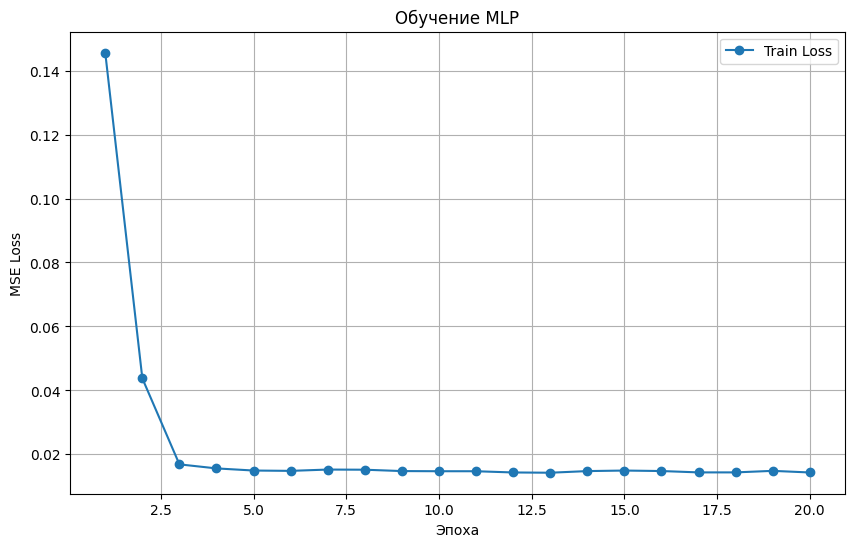

In [ ]:
epochs = 20
train_loss_history = []
test_loss_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(epoch_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")


plt.figure(figsize=(10,6))
plt.plot(range(1, epochs+1), train_loss_history, label='Train Loss', marker='o')
plt.xlabel("Эпоха")
plt.ylabel("MSE Loss")
plt.title("Обучение MLP")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
full_dataset = CampaignDataset(X, y)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)

model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in full_loader:
        xb = xb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())

all_preds = np.vstack(all_preds)


In [ ]:
validate_preds["mlp_1"] = all_preds[:, 0]
validate_preds["mlp_2"] = all_preds[:, 1]
validate_preds["mlp_3"] = all_preds[:, 2]


In [ ]:
validate_preds

,at_least_one,at_least_two,at_least_three,cb_1,cb_2,cb_3,mlp_1,mlp_2,mlp_3
0,0.0430,0.0152,0.0073,0.040291,0.012881,0.006675,0.025411,0.010682,0.006899
1,0.0130,0.0000,0.0000,0.016644,0.000818,0.001651,0.023617,0.009620,0.006451
2,0.0878,0.0135,0.0000,0.085867,0.010858,-0.000130,0.110115,0.057120,0.041671
3,0.2295,0.1295,0.0727,0.236661,0.135183,0.078658,0.244601,0.161882,0.113259
4,0.3963,0.2785,0.2270,0.401565,0.281866,0.226782,0.171166,0.092974,0.057142
...,...,...,...,...,...,...,...,...,...
1003,0.0679,0.0408,0.0190,0.053544,0.012306,0.006624,0.042732,0.019169,0.014772
1004,0.0165,0.0000,0.0000,0.014857,-0.001293,-0.000550,0.115928,0.065020,0.051266
1005,0.0071,0.0000,0.0000,0.011270,-0.001230,-0.000458,0.112142,0.062209,0.045948
1006,0.3669,0.2628,0.2066,0.362507,0.263301,0.204346,0.220962,0.129155,0.090942


In [ ]:
class Transformer(Dataset):
    def __init__(self, df, user_agg, max_seq_len=50):
        self.df = df
        self.user_agg = user_agg
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        user_ids = row['user_ids']
        publishers = row['publishers']

        user_feats = self.user_agg[self.user_agg['user_id'].isin(user_ids)][
            ['total_impressions','mean_cpm','median_cpm','max_cpm']
        ].values.astype(np.float32)
        if len(user_feats) > self.max_seq_len:
            user_feats = user_feats[:self.max_seq_len]
        if len(user_feats) < self.max_seq_len:
            padding = np.zeros((self.max_seq_len - len(user_feats), user_feats.shape[1]), dtype=np.float32)
            user_feats = np.vstack([user_feats, padding])


        hour_start = row['hour_start_of_day']
        hour_end = row['hour_end_of_day']
        publishers_ids = np.array(publishers, dtype=np.int64)
        if len(publishers_ids) < self.max_seq_len:
            publishers_ids = np.pad(publishers_ids, (0, self.max_seq_len - len(publishers_ids)), 'constant', constant_values=0)
        else:
            publishers_ids = publishers_ids[:self.max_seq_len]

        y = row[['at_least_one','at_least_two','at_least_three']].values.astype(np.float32)

        return (torch.tensor(user_feats),
                torch.tensor(hour_start, dtype=torch.long),
                torch.tensor(hour_end, dtype=torch.long),
                torch.tensor(publishers_ids, dtype=torch.long),
                torch.tensor(y, dtype=torch.float32))


In [ ]:
class CampaignTransformer(nn.Module):
    def __init__(self, input_dim, max_hour=24, hour_emb_dim=4, max_publisher_id=1000, pub_emb_dim=8, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        self.hour_start_emb = nn.Embedding(max_hour, hour_emb_dim)
        self.hour_end_emb = nn.Embedding(max_hour, hour_emb_dim)
        self.pub_emb = nn.Embedding(max_publisher_id, pub_emb_dim)

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model + 2*hour_emb_dim + pub_emb_dim, nhead=nhead, dropout=dropout, batch_first=True),
            num_layers=num_layers
        )
        self.fc_out = nn.Linear(d_model + 2*hour_emb_dim + pub_emb_dim, 3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_num, hour_start, hour_end, pub_ids):
        h_start_emb = self.hour_start_emb(hour_start).unsqueeze(1).repeat(1, x_num.size(1), 1)
        h_end_emb = self.hour_end_emb(hour_end).unsqueeze(1).repeat(1, x_num.size(1), 1)
        pub_emb = self.pub_emb(pub_ids)

        x = torch.cat([self.input_fc(x_num), h_start_emb, h_end_emb, pub_emb], dim=-1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.sigmoid(self.fc_out(x))

In [ ]:
dataset = Transformer(validate, user_agg, max_seq_len=50)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 4
model = CampaignTransformer(input_dim=input_dim, max_publisher_id=validate['publishers'].explode().max()+1).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 1/25, Loss: 0.0170
Epoch 2/25, Loss: 0.0150
Epoch 3/25, Loss: 0.0151
Epoch 4/25, Loss: 0.0148
Epoch 5/25, Loss: 0.0151
Epoch 6/25, Loss: 0.0151
Epoch 7/25, Loss: 0.0148
Epoch 8/25, Loss: 0.0141
Epoch 9/25, Loss: 0.0138
Epoch 10/25, Loss: 0.0136
Epoch 11/25, Loss: 0.0139
Epoch 12/25, Loss: 0.0139
Epoch 13/25, Loss: 0.0136
Epoch 14/25, Loss: 0.0136
Epoch 15/25, Loss: 0.0138
Epoch 16/25, Loss: 0.0138
Epoch 17/25, Loss: 0.0138
Epoch 18/25, Loss: 0.0138
Epoch 19/25, Loss: 0.0139
Epoch 20/25, Loss: 0.0137
Epoch 21/25, Loss: 0.0135
Epoch 22/25, Loss: 0.0137
Epoch 23/25, Loss: 0.0135
Epoch 24/25, Loss: 0.0136
Epoch 25/25, Loss: 0.0135


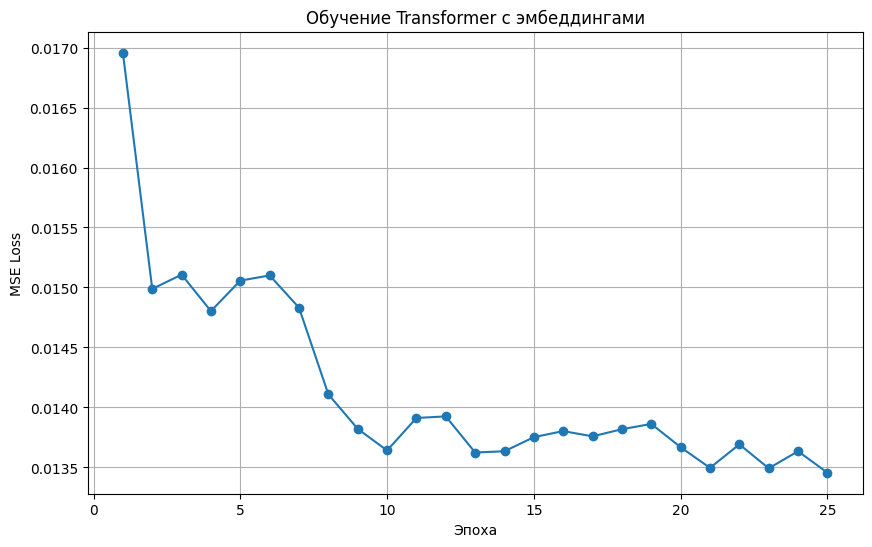

In [ ]:
epochs = 25
loss_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb_num, xb_hour_start, xb_hour_end, xb_pub, yb in loader:
        xb_num, xb_hour_start, xb_hour_end, xb_pub, yb = xb_num.to(device), xb_hour_start.to(device), xb_hour_end.to(device), xb_pub.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb_num, xb_hour_start, xb_hour_end, xb_pub)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb_num.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

plt.figure(figsize=(10,6))
plt.plot(range(1, epochs+1), loss_history, marker='o')
plt.xlabel("Эпоха")
plt.ylabel("MSE Loss")
plt.title("Обучение Transformer с эмбеддингами")
plt.grid(True)
plt.show()



In [ ]:
model.eval()
all_preds = []
with torch.no_grad():
    for xb_num, xb_hour_start, xb_hour_end, xb_pub, _ in loader:
        xb_num, xb_hour_start, xb_hour_end, xb_pub = xb_num.to(device), xb_hour_start.to(device), xb_hour_end.to(device), xb_pub.to(device)
        preds = model(xb_num, xb_hour_start, xb_hour_end, xb_pub)
        all_preds.append(preds.cpu().numpy())

all_preds = np.vstack(all_preds)

validate_preds["trans_1"] = all_preds[:, 0]
validate_preds["trans_2"] = all_preds[:, 1]
validate_preds["trans_3"] = all_preds[:, 2]

In [ ]:
class RNNDataset(Dataset):
    def __init__(self, X, y, seq_len=5):
        self.X = torch.tensor(X.values if isinstance(X, pd.DataFrame) else X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        if x_seq.shape[0] < self.seq_len:
            padding = torch.zeros((self.seq_len - x_seq.shape[0], self.X.shape[1]))
            x_seq = torch.cat([x_seq, padding], dim=0)
        return x_seq, self.y[idx]

class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, output_dim=3):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return self.sigmoid(out)

In [ ]:
seq_len = 5
dataset = RNNDataset(X_train, y_train, seq_len=seq_len)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_model = SimpleRNN(input_dim=X_train.shape[1], hidden_dim=64, num_layers=1).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=1e-3)

Epoch 1/25, Loss: 0.1284
Epoch 2/25, Loss: 0.0343
Epoch 3/25, Loss: 0.0210
Epoch 4/25, Loss: 0.0180
Epoch 5/25, Loss: 0.0170
Epoch 6/25, Loss: 0.0164
Epoch 7/25, Loss: 0.0161
Epoch 8/25, Loss: 0.0159
Epoch 9/25, Loss: 0.0158
Epoch 10/25, Loss: 0.0157
Epoch 11/25, Loss: 0.0157
Epoch 12/25, Loss: 0.0156
Epoch 13/25, Loss: 0.0155
Epoch 14/25, Loss: 0.0155
Epoch 15/25, Loss: 0.0155
Epoch 16/25, Loss: 0.0155
Epoch 17/25, Loss: 0.0155
Epoch 18/25, Loss: 0.0155
Epoch 19/25, Loss: 0.0155
Epoch 20/25, Loss: 0.0155
Epoch 21/25, Loss: 0.0155
Epoch 22/25, Loss: 0.0155
Epoch 23/25, Loss: 0.0154
Epoch 24/25, Loss: 0.0155
Epoch 25/25, Loss: 0.0154


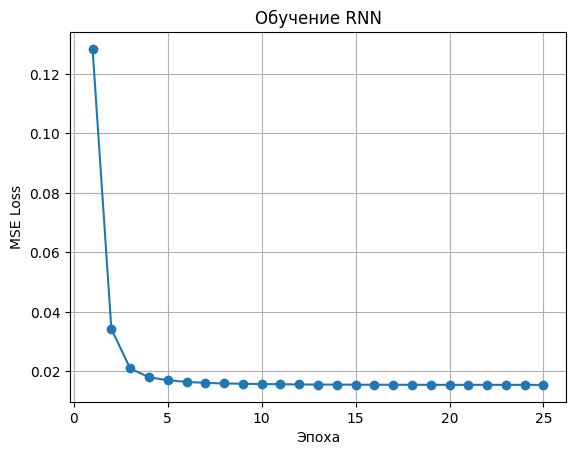

In [ ]:
epochs = 25
loss_history = []

for epoch in range(epochs):
    rnn_model.train()
    running_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = rnn_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")



import matplotlib.pyplot as plt
plt.plot(range(1, epochs+1), loss_history, marker='o')
plt.xlabel("Эпоха")
plt.ylabel("MSE Loss")
plt.title("Обучение RNN")
plt.grid(True)
plt.show()


In [ ]:
rnn_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in DataLoader(RNNDataset(X, y, seq_len=seq_len), batch_size=32):
        xb = xb.to(device)
        preds = rnn_model(xb)
        all_preds.append(preds.cpu().numpy())

all_preds = np.vstack(all_preds)
validate_preds["rnn_1"] = all_preds[:, 0]
validate_preds["rnn_2"] = all_preds[:, 1]
validate_preds["rnn_3"] = all_preds[:, 2]

Метрики

In [46]:
def smoothed_mean_log_accuracy_ratio(y_true, y_pred, epsilon=0.005):
    y_true = np.array(y_true, dtype=np.float64)
    y_pred = np.array(y_pred, dtype=np.float64)

    ratio = (y_pred + epsilon) / (y_true + epsilon)
    ratio[ratio <= 0] = epsilon

    smlr = np.mean(np.abs(np.log(ratio)))
    return 100 * (np.exp(smlr) - 1)


In [ ]:
target_cols = ["at_least_one", "at_least_two", "at_least_three"]
model_prefixes = ["cb", "mlp", "trans", "rnn"]

metrics = {}

for i, target in enumerate(target_cols):
    metrics[target] = {}
    y_true = validate_preds[target].values
    for prefix in model_prefixes:
        y_pred = validate_preds[f"{prefix}_{i+1}"].values
        metrics[target][prefix] = smoothed_mean_log_accuracy_ratio(y_true, y_pred)
metrics_df = pd.DataFrame(metrics)
metrics_df

,at_least_one,at_least_two,at_least_three
cb,16.072284,21.738328,22.790465
mlp,177.193466,325.424199,336.481575
trans,240.253205,419.171801,445.627537
rnn,239.519727,430.405192,437.700164


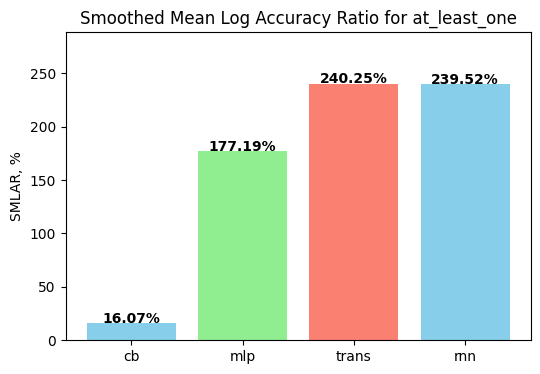

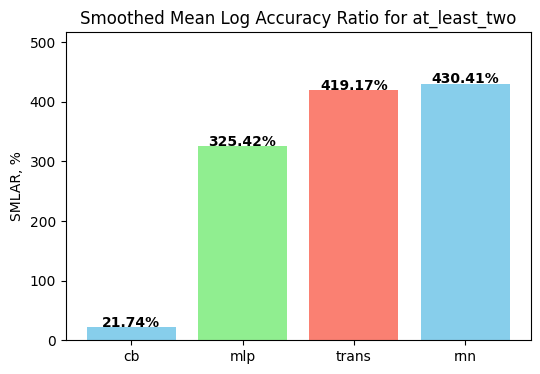

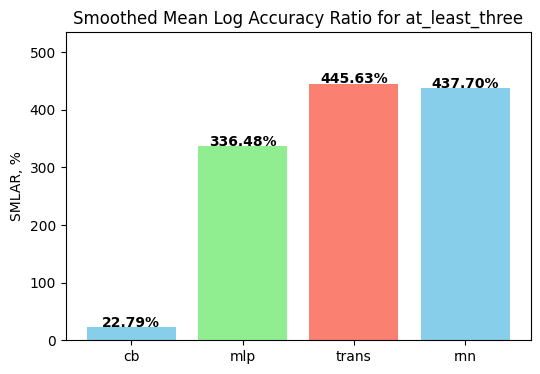

In [ ]:
for target in target_cols:
    plt.figure(figsize=(6,4))
    values = [metrics[target][prefix] for prefix in model_prefixes]
    plt.bar(model_prefixes, values, color=['skyblue', 'lightgreen', 'salmon'])
    plt.ylabel("SMLAR, %")
    plt.title(f"Smoothed Mean Log Accuracy Ratio for {target}")
    plt.ylim(0, max(values)*1.2)
    for i, v in enumerate(values):
        plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', fontweight='bold')
    plt.show()


In [ ]:
results = []

for prefix in model_prefixes:
    for i, target in enumerate(target_cols):
        y_true = validate_preds[target].values
        y_pred = validate_preds[f"{prefix}_{i+1}"].values

        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        results.append({
            "model": prefix,
            "target": target,
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        })

results_df = pd.DataFrame(results)
print(results_df)


    model          target       MSE      RMSE       MAE        R2
0      cb    at_least_one  0.000256  0.015996  0.007074  0.988008
1      cb    at_least_two  0.000225  0.014985  0.005065  0.983806
2      cb  at_least_three  0.000178  0.013345  0.004214  0.981821
3     mlp    at_least_one  0.017496  0.132272  0.094094  0.180039
4     mlp    at_least_two  0.012307  0.110938  0.072484  0.112415
5     mlp  at_least_three  0.008963  0.094673  0.057453  0.085144
6   trans    at_least_one  0.022966  0.151545  0.110217 -0.076315
7   trans    at_least_two  0.014441  0.120170  0.080153 -0.041455
8   trans  at_least_three  0.010259  0.101286  0.064918 -0.047146
9     rnn    at_least_one  0.021560  0.146834  0.108820 -0.010430
10    rnn    at_least_two  0.013865  0.117750  0.080024  0.000061
11    rnn  at_least_three  0.009897  0.099483  0.062974 -0.010182


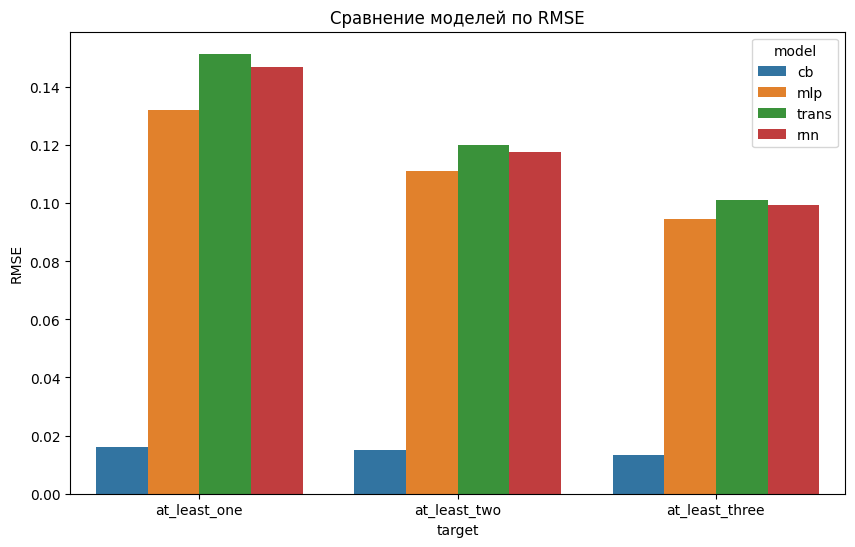

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="target", y="RMSE", hue="model")
plt.title("Сравнение моделей по RMSE")
plt.show()


In [ ]:
model1.save_model("best_catboost_model.cbm")
from google.colab import files
files.download("best_catboost_model.cbm")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>